In [5]:
import sys
import os
import clmm
import clmm.dataops
from clmm.dataops import compute_tangential_and_cross_components, make_radial_profile, make_bins
from clmm.galaxycluster import GalaxyCluster
import clmm.utils as u
from clmm import Cosmology
from clmm.support import mock_data as mock
cosmo = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)

import numpy as np
import pyccl as ccl
import numpy as np
import sys
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
from scipy.integrate import quad,simps, dblquad
from scipy.optimize import curve_fit

In [6]:
clmm.__version__

'0.9.2'

In [7]:
sys.path.append('/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/modeling')
import miscentering as mis
import two_halo_term as twoh

In [8]:
cluster_m = 1e14
cluster_z = 0.5
concentration = 3
moo = clmm.Modeling(massdef = 'critical', delta_mdef = 200, halo_profile_model = 'einasto')
mock_cosmo = Cosmology(H0=70.0, Omega_dm0=0.27-0.045, Omega_b0=0.045, Omega_k0=0.0)
cosmo_ccl = ccl.Cosmology(Omega_c=0.27-0.045, Omega_b=0.045, h=0.7, A_s=2.1e-9, n_s=0.96, Neff=0, Omega_g=0)
moo.set_cosmo(mock_cosmo)
moo.set_mass(cluster_m) 
moo.set_concentration(concentration)

### Compute Miscentering

In [43]:
R = np.logspace(np.log10(0.1), np.log10(10), 100)

In [44]:
def s(R,a):
    b = 1
    return a**2*moo.eval_surface_density(R*a, cluster_z)

In [45]:
def ds(R,a):
    b = 1
    return a**2*moo.eval_excess_surface_density(R*a, cluster_z)

In [46]:
a_ = np.linspace(0.3,2,10)
b_ = [4, 3, 2, 1]
delta = 0.01

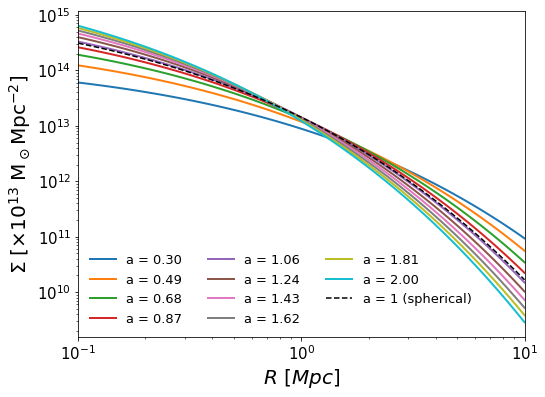

In [47]:
plt.figure(figsize = (8,6))

for i,a in enumerate(a_): 
    
    plt.loglog(R,s(R, a), '-', label = f'a = {a:.2f}', linewidth = 2)
    
plt.plot(R, s(R, 1), '--k', label = f'a = {1} (spherical)')
plt.xlabel(r'$R\ [Mpc]$', fontsize = 20)
plt.ylabel(r'$\Sigma$ ' +'$[$' + r'$\times 10^{13}$ ' + r'${\rm M}$' + r'$_\odot$'+ r'${\rm Mpc}$'+r'$^{-2}$'r'$]$', fontsize = 20)
plt.legend(fontsize = 13, frameon = False, ncol = 3)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.xlim(min(R),max(R))
plt.savefig('/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/pro_s.png', dpi = 300)

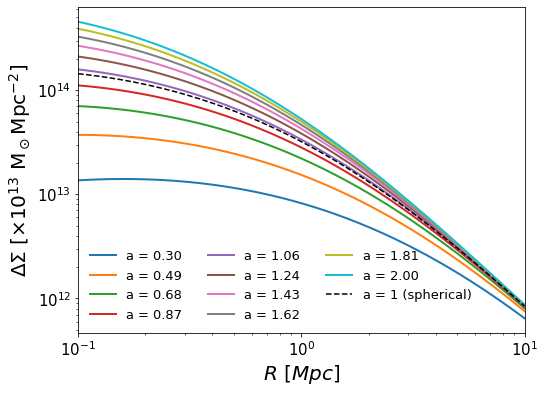

In [48]:
plt.figure(figsize = (8,6))

for i,a in enumerate(a_): 
    
    plt.loglog(R,ds(R, a), '-', label = f'a = {a:.2f}', linewidth = 2)
    
plt.plot(R, ds(R, 1), '--k', label = f'a = {1} (spherical)')
plt.xlabel(r'$R\ [Mpc]$', fontsize = 20)
plt.ylabel(r'$\Delta\Sigma$ ' +'$[$' + r'$\times 10^{13}$ ' + r'${\rm M}$' + r'$_\odot$'+ r'${\rm Mpc}$'+r'$^{-2}$'r'$]$', fontsize = 20)
plt.legend(fontsize = 13, frameon = False, ncol = 3)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.xlim(min(R),max(R))
plt.savefig('/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/pro_ds.png', dpi = 300)

In [25]:
def dM(R,a):
    return R*((a**2))*moo.eval_surface_density(R*a, cluster_z)

In [26]:
def M(R,a):
    return quad(dM,0.,R,args = (a))[0]

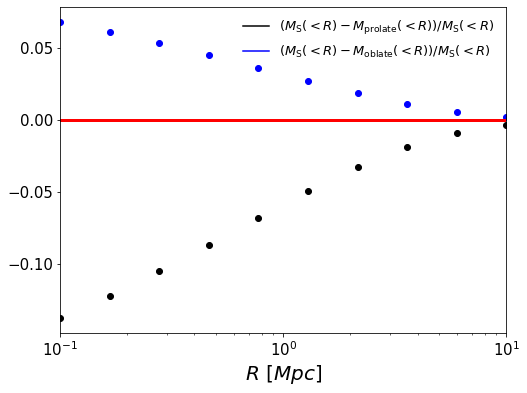

In [30]:
R = np.logspace(np.log10(0.1), np.log10(10), 10)
plt.figure(figsize = (8,6))
Eo_ein, Ep_ein,  = [], []
Eo_nfw, Ep_nfw,  = [], []

for r in R:
    plt.scatter(r,(M(r,1) - M(r,1.1))/M(r,1), c='k')
    plt.scatter(r,(M(r,1) - M(r,0.95))/M(r,1), c='b')

plt.xscale('log')
plt.plot([],[], 'k', label = r'$(M_{\rm S}(<R) - M_{\rm prolate}(<R))/M_{\rm S}(<R)$')
plt.plot([],[], 'b', label = r'$(M_{\rm S}(<R) - M_{\rm oblate}(<R))/M_{\rm S}(<R)$')
plt.plot(R,0*R,'r',linewidth = 3)
plt.legend(fontsize = 13, frameon = False)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.xlim(min(R),max(R))
plt.xlabel(r'$R\ [Mpc]$', fontsize = 20)
plt.savefig('/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/pro_obl.png',bbox_inches='tight', dpi = 300)

# bias on Mass reconstruction

In [436]:
a_list = np.linspace(0.8,1.2,5)

In [437]:
deff = ccl.halos.massdef.MassDef(200, 'critical', c_m_relation=None)
conc = ccl.halos.concentration.ConcentrationDiemer15(mdef=deff)

In [438]:
moo_fit = clmm.Modeling(massdef = 'critical', delta_mdef = 200, halo_profile_model = 'einasto')
moo_fit.set_cosmo(mock_cosmo)
def ds_fit(R, logm, c):
    moo_fit.set_mass(10**logm) 
    moo_fit.set_concentration(c)
    return moo_fit.eval_excess_surface_density(R, cluster_z)

In [439]:
cluster_m = 1e14
cluster_z = 0.5
concentration = 4
moo_true = clmm.Modeling(massdef = 'critical', delta_mdef = 200, halo_profile_model = 'einasto')
moo_true.set_cosmo(mock_cosmo)
moo_true.set_mass(cluster_m) 
moo_true.set_concentration(concentration)

In [440]:
    moo_true.set_halo_density_profile('nfw')

In [417]:
def ds(R,a):
    return a**2*moo_true.eval_excess_surface_density(R*a, cluster_z)

In [535]:
c_fit_ein, logm_fit_ein = [], []
c_fit_err_ein, logm_fit_err_ein = [], []
R = np.logspace(np.log10(0.1), np.log10(10), 1000)
for i,a in enumerate(a_list):
    moo_true.set_halo_density_profile('einasto')
    ds_obs_ein = ds(R,a)
    moo_fit.set_halo_density_profile('einasto')
    popt_ein, cov_ein = curve_fit(ds_fit, R, ds_obs_ein, p0 = [np.log10(cluster_m),concentration], bounds = ([10,0],[16,10]))
    c_fit_ein.append(popt_ein[1]), c_fit_err_ein.append(cov_ein[1,1])
    logm_fit_ein.append(popt_ein[0]), logm_fit_err_ein.append(cov_ein[0,0])
    
c_fit_ein, logm_fit_ein = np.array(c_fit_ein), np.array(logm_fit_ein)

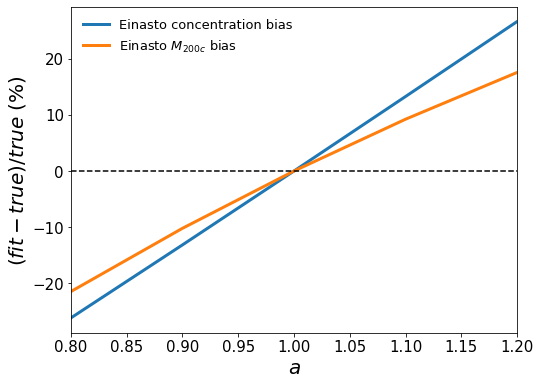

In [536]:
plt.figure(figsize = (8,6))
plt.plot(a_list, 100*(c_fit_ein - concentration)/concentration, label = 'Einasto concentration bias', linewidth = 3)
plt.plot(a_list, 100*(10**logm_fit_ein - cluster_m)/cluster_m, label = 'Einasto $M_{200c}$ bias', linewidth = 3)
plt.legend(fontsize = 13, frameon = False)
plt.plot(a_list, np.zeros(len(a_list)), '--k')
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.ylabel(r'$(fit-true)/true\ (\%)$', fontsize = 20)
plt.xlabel(r'$a$', fontsize = 20)
plt.xlim(min(a_list),max(a_list))
plt.savefig('/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/pro_obl_c_m_fit.png',bbox_inches='tight', dpi = 300)

In [445]:
from itertools import combinations

In [446]:
a = np.linspace(1,2,3)

In [447]:
def combinatory(X):
    
    dimension = len(X)
    
    mesh = np.array(np.meshgrid(*X))
    
    combinations = mesh.T.reshape(-1, dimension)
    
    Xcomb = combinations.T
        
    return Xcomb

In [504]:
phi = np.random.random(1000)*(2*np.pi)
Phi = np.random.random(1000)*(2*np.pi)

In [505]:
phi_comb, Phi_comb = combinatory([phi, Phi])

In [521]:
def f1(x,y,a):
    return -1j*np.exp(-1j*a*np.cos(x-y))*np.cos(x-y)/((2*np.pi)**2)

In [522]:
def f2(x,y,a):
    return -1j*np.exp(-1j*a*np.cos(x-y))*np.cos(x+y)/((2*np.pi)**2)

In [523]:
def F(f,a):
    
    integrand = f(phi_comb,Phi_comb,a)
    d2phi = (2*np.pi)**2/(len(phi)*len(Phi))
    
    return np.sum(integrand)*d2phi

In [524]:
F(f2,1)

(-0.018311953463345427+0.00012960427009394996j)

In [525]:
R = np.linspace(0,10,50)
d2 = []
d1 = []
for r in R:
    d1.append(F(f1,r)), d2.append(F(f2,r))

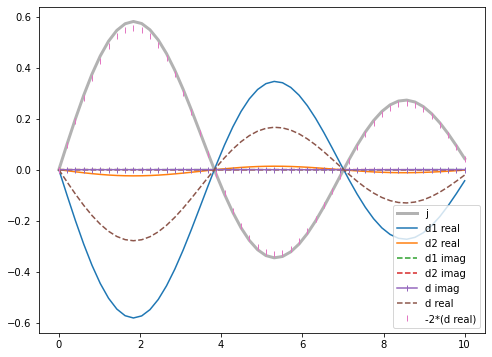

In [530]:
from scipy.special import jv
plt.figure(figsize = (8,6))
d1, d2 = np.array(d1), np.array(d2)
d = 0.5*(np.array(d1) - np.array(d2))
plt.plot(R,jv(1,R),'k',label = 'j', linewidth = 3, alpha = 0.3)
plt.plot(R,np.array(d1).real, '-', label = 'd1 real')
plt.plot(R,np.array(d2).real, '-', label = 'd2 real')
plt.plot(R,np.array(d1).imag, '--', label = 'd1 imag')
plt.plot(R,np.array(d2).imag, '--', label = 'd2 imag')
plt.plot(R,np.array(d).imag, '|-', label = 'd imag')
plt.plot(R,np.array(d).real, '--', label = 'd real')
plt.plot(R,(-2.)*np.array(d).real, '|', label = '-2*(d real)')
plt.legend()

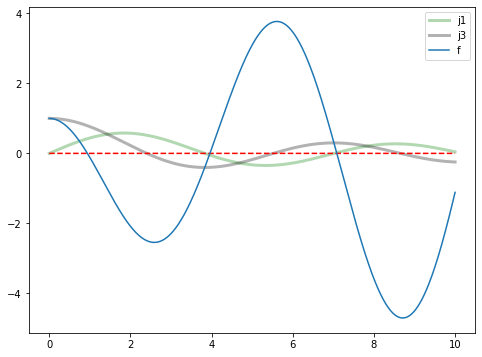

In [605]:
from scipy.special import jv
plt.figure(figsize = (8,6))
R = np.linspace(0,10,10000)
plt.plot(R,jv(1,R),'g',label = 'j1', linewidth = 3, alpha = 0.3)
plt.plot(R,jv(0,R),'k',label = 'j3', linewidth = 3, alpha = 0.3)
eff = (jv(0,R)-2*R*jv(1,R))
plt.plot(R,0*R, '--r')
plt.plot(R,eff, label = 'f')
plt.legend()


In [664]:
def f(r): return moo.eval_3d_density(r, cluster_z)
    

In [674]:
def g(R, a):
    b = 1./(a**2)
    def fy(y):
        r = np.sqrt(a*R**2 + b*y**2)
        return f(r)
    return quad(fy, -1e3,1e3)[0]

In [677]:
R = np.logspace(-1,1,10)
pro = []
pro1 = []
pro2 = []

for RR in R:
    pro.append(g(RR, 1))
    pro1.append(g(RR, 1.5))
    pro2.append(g(RR, 0.5))

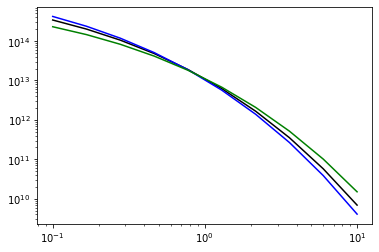

In [678]:
plt.loglog(R,pro, 'k')
plt.plot(R,pro1, 'b')
plt.plot(R,pro2, 'g')